# Pricing Challenge


## Goal


The goal here is to evaluate whether a pricing test running on the site has been successful. User segmentation and providing insights about segments who behave differently as well as any other insights are the focuses of this project.


## Background


Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($39), while a random sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

Especially he asked you the following questions:

1. Should the company sell its software for $39 or $59?

2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

3. The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why.

Thought Process Summary

To solve the problem 1, I would need to find out:(1) if the change in price leads to the change in the conversion rate; (2) if this happens to all segmentations. 
So, I am going to: 
(1) exam the significance of the difference in conversion rate between the test group faced with the higher price and the other group by using t test. 
(2) use the Partial Dependence Plots to visualize the difference among segmentions. 
(3) Based on the Partial Dependence Plots, I will select the ones with noticeable difference and use one-way multi-variate analysis of variance to test if each segmentation has the same conversion rate.

For the problem 2, 

### Preparation

In [1]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import date, timedelta


import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
test = pd.read_csv('test_results.csv',parse_dates=['timestamp'])

In [3]:
user = pd.read_csv('user_table.csv')

In [4]:
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
test['timestamp_1'] = test['timestamp'].str.replace('60','59')

In [7]:
test['timestamp_1'] = pd.to_datetime(test['timestamp_1'])

In [8]:
df = pd.merge(user,test, how='outer')

In [9]:
df['timestamp_2']=df['timestamp_1'].map(lambda x: x.timestamp()/10**5)
df_1 = df[df['test']==1]
df_0 = df[df['test']==0]
df_1_nloc = df[(df['test']==1)&(~df['lat'].isna())]
df_0_nloc = df[(df['test']==0)&(~df['lat'].isna())]

In [10]:
df.head()

,user_id,city,country,lat,long,timestamp,source,device,operative_system,test,price,converted,timestamp_1,timestamp_2
0,510335,Peabody,USA,42.53,-70.97,2015-05-02 12:06:41,ads-google,mobile,android,0,39,0,2015-05-02 12:06:41,14305.68401
1,89568,Reno,USA,39.54,-119.82,2015-04-30 16:02:01,ads_facebook,mobile,android,1,59,0,2015-04-30 16:02:01,14304.09721
2,434134,Rialto,USA,34.11,-117.39,2015-05-16 19:53:40,direct_traffic,web,windows,1,59,0,2015-05-16 19:53:40,14318.06020
3,289769,Carson City,USA,39.15,-119.74,2015-04-23 18:50:58,ads_facebook,web,windows,0,39,0,2015-04-23 18:50:58,14298.15058
4,939586,Chicago,USA,41.84,-87.68,2015-03-08 13:53:10,ads_facebook,mobile,iOS,1,59,0,2015-03-08 13:53:10,14258.22790


### Univariate Analysis

In [43]:
def mean_count(dt,group_var,target_var):
    mean = pd.DataFrame(dt.groupby(group_var)[target_var].mean()).reset_index()
    mean.columns = [group_var,'mean']
    count = pd.DataFrame(dt.groupby(group_var)[target_var].count()).reset_index()
    count.columns = [group_var,'count']
    mc = pd.merge(left=mean,right=count, left_on=group_var, right_on=group_var)
    return mc
def mc_plot(df,groupvar):
    fig, ax = plt.subplots(figsize=(16,4))
    sns.lineplot(x=df[groupvar], 
                 y=df['mean'],
                 color='r',
                 ax=ax)
    sns.lineplot(x=df[groupvar], 
                 y=df['count_s'], 
                 color='b',
                 ax=ax)    
    ax.legend(['mean', 'count'], facecolor='w')
    plt.show()
def mc_plot2(df,groupvar):
    fig, ax = plt.subplots(figsize=(16,4))
    sns.lineplot(x=df[groupvar], 
                 y=df['mean'],
                 color='r',
                 ax=ax)
    sns.lineplot(x=df[groupvar], 
                 y=df['count'], 
                 color='b',
                 ax=ax)
    sns.lineplot(x=df[groupvar], 
                 y=df['count_1'], 
                 color='g',
                 ax=ax) 
    ax.legend(['mean_diff', 'conntrol_size','test_size'], facecolor='w')
    plt.show()

In [41]:
def check_diff(dt,count_var,mean_var): 
    n_0 = dt[count_var][0]
    p_0 = dt[mean_var][0]
    var_0_mean = ((n_0*(1-p_0)*(0-p_0)**2+n_0*p_0*(1-p_0)**2)/(n_0-1))/n_0**0.5
    n_1 = dt[count_var][1]
    p_1 = dt[mean_var][1]
    var_1_mean = ((n_1*(1-p_1)*(0-p_1)**2+n_1*p_1*(1-p_1)**2)/(n_1-1))/n_1**0.5
    p_diff = p_0-p_1
    var_diff = var_0_mean+var_1_mean
    std_diff = var_diff**0.5
    return (std_diff*1.96<p_diff)or(std_diff*(-1.96)>p_diff)

In [67]:
def test_loop(df):
    res = []
    for i in df.iterrows():
        n_0 = i[1][2]
        p_0 = i[1][1]
        var_0_mean = ((n_0*(1-p_0)*(0-p_0)**2+n_0*p_0*(1-p_0)**2)/(n_0-1))/n_0**0.5
        n_1 = i[1][5]
        p_1 = i[1][4]
        var_1_mean = ((n_1*(1-p_1)*(0-p_1)**2+n_1*p_1*(1-p_1)**2)/(n_1-1))/n_1**0.5
        p_diff = p_0-p_1
        var_diff = var_0_mean+var_1_mean
        std_diff = var_diff**0.5
        res.append((std_diff*1.96<p_diff)or(std_diff*(-1.96)>p_diff))
        if any(res):
            return res
        else: return 0

#### Overall

In [39]:
test_mc = mean_count(df,group_var='test',target_var='converted')

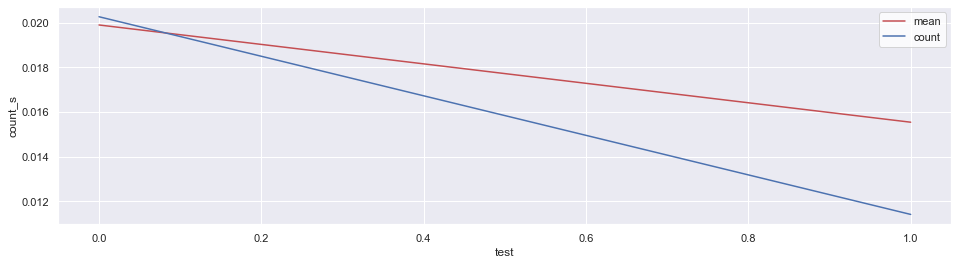

In [44]:
test_mc['count_s'] = test_mc['count'] /10**7
mc_plot(test_mc,groupvar = 'test')

In [40]:
test_mc

,test,mean,count
0,0,0.019904,202727
1,1,0.015543,114073


In [42]:
check_diff(test_mc,'count','mean')

False

According to the test on the difference between the distribution with the price being 39 and the distribution with the price being 59, there is no significant change on the conversion rate overall.

For the next step, I would check whether there is a significant change in each segmentation.

#### Source

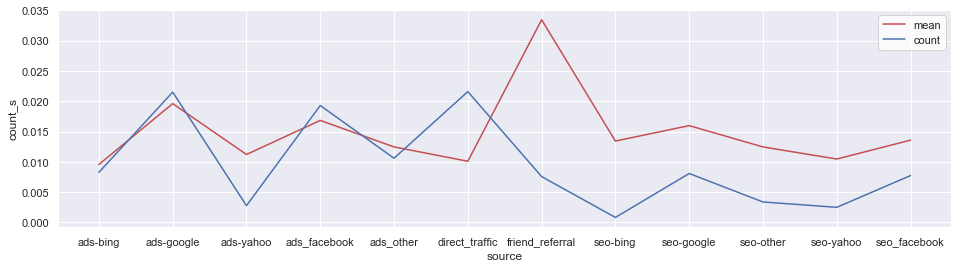

In [45]:
source_mc_1 = mean_count(df_1,group_var='source',target_var='converted')
source_mc_1['count_s'] = source_mc_1['count'] /10**6
mc_plot(source_mc_1,groupvar = 'source')

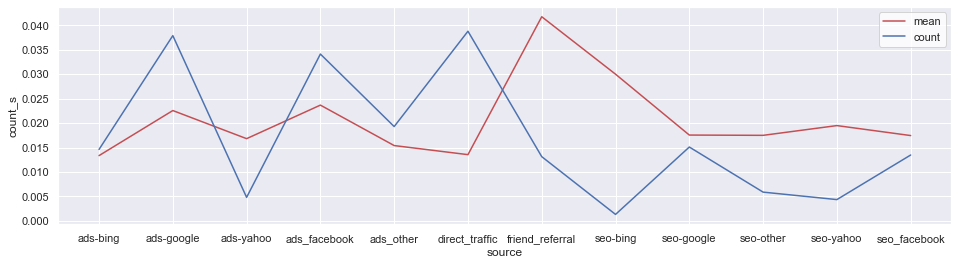

In [48]:
source_mc_0 = mean_count(df_0,group_var='source',target_var='converted')
source_mc_0['count_s'] = source_mc_0['count'] /10**6
mc_plot(source_mc_0,groupvar = 'source')

In [54]:
source_mc_1.columns = ['source','mean_1','count_1','count_s_1']
source_mc_1['mean_0'] = source_mc_0['mean']
source_mc_1['count_0'] = source_mc_0['count']
source_mc_1

,source,mean_1,count_1,count_s_1,mean_0,count_0
0,ads-bing,0.009560,8264,0.008264,0.013348,14609
1,ads-google,0.019614,21515,0.021515,0.022554,37864
2,ads-yahoo,0.011212,2765,0.002765,0.016812,4818
3,ads_facebook,0.016842,19297,0.019297,0.023666,34099
4,ads_other,0.012462,10592,0.010592,0.015401,19284
5,direct_traffic,0.010094,21598,0.021598,0.013545,38759
6,friend_referral,0.033466,7560,0.007560,0.041721,13135
7,seo-bing,0.013431,819,0.000819,0.029985,1334
8,seo-google,0.015979,8073,0.008073,0.017547,15102
9,seo-other,0.012459,3371,0.003371,0.017490,5889


In [68]:
test_loop(source_mc_1)

0

In [ ]:
n_0 = dt[count_var][0]
p_0 = dt[mean_var][0]
var_0_mean = ((n_0*(1-p_0)*(0-p_0)**2+n_0*p_0*(1-p_0)**2)/(n_0-1))/n_0**0.5
n_1 = dt[count_var][1]
p_1 = dt[mean_var][1]
var_1_mean = ((n_1*(1-p_1)*(0-p_1)**2+n_1*p_1*(1-p_1)**2)/(n_1-1))/n_1**0.5
p_diff = p_0-p_1
var_diff = var_0_mean+var_1_mean
std_diff = var_diff**0.5
return (std_diff*1.96<p_diff)or(std_diff*(-1.96)>p_diff)

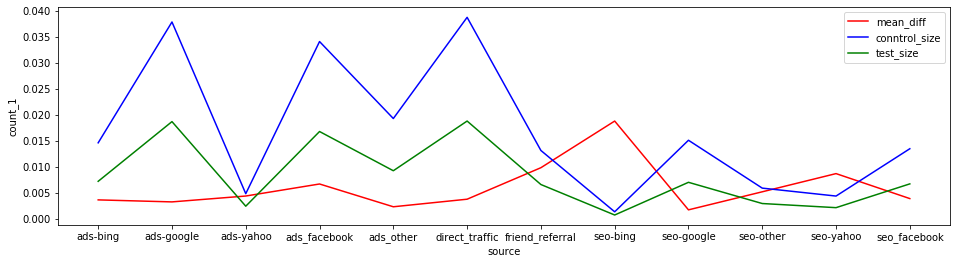

In [19]:
source_mc_0 = mean_count(df_0,group_var='source',target_var='converted')
source_mc_0['count'] = source_mc_0['count'] /(10**6)
source_mc_1 = mean_count(df_1_nloc,group_var='source',target_var='converted')
source_mc_1['count'] = source_mc_1['count'] /(10**6)
source_mc_0['mean'] = source_mc_0['mean'] - source_mc_1['mean']
source_mc_0['count_1'] = source_mc_1['count']
mc_plot2(source_mc_0,groupvar = 'source')

In [20]:
source_mc_0

,source,mean,count,count_1
0,ads-bing,0.003626,0.014609,0.007200
1,ads-google,0.003239,0.037864,0.018690
2,ads-yahoo,0.004369,0.004818,0.002411
3,ads_facebook,0.006686,0.034099,0.016784
4,ads_other,0.002300,0.019284,0.009236
5,direct_traffic,0.003757,0.038759,0.018799
6,friend_referral,0.009820,0.013135,0.006583
7,seo-bing,0.018796,0.001334,0.000715
8,seo-google,0.001708,0.015102,0.007008
9,seo-other,0.005183,0.005889,0.002925


#### Device

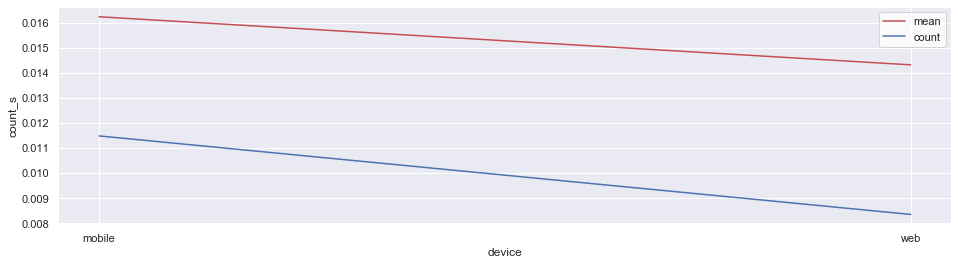

In [69]:
device_mc_1 = mean_count(df_1_nloc,group_var='device',target_var='converted')
device_mc_1['count_s'] = device_mc_1['count'] /(5*10**6)
mc_plot(device_mc_1,groupvar = 'device')

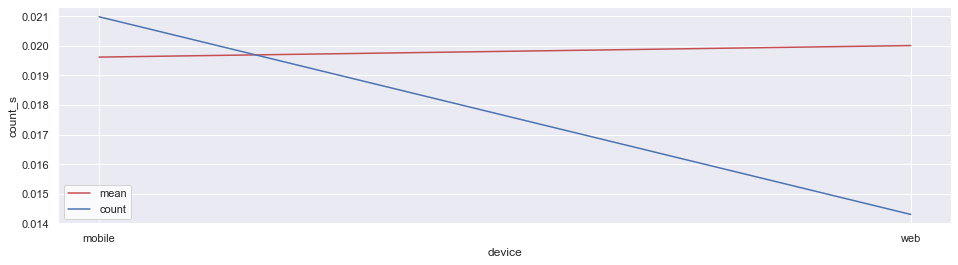

In [70]:
device_mc_0 = mean_count(df_0_nloc,group_var='device',target_var='converted')
device_mc_0['count_s'] = device_mc_0['count'] /(5*10**6)
mc_plot(device_mc_0,groupvar = 'device')

In [71]:
device_mc_1.columns = ['source','mean_1','count_1','count_s_1']
device_mc_1['mean_0'] = device_mc_0['mean']
device_mc_1['count_0'] = device_mc_0['count']
device_mc_1

,source,mean_1,count_1,count_s_1,mean_0,count_0
0,mobile,0.016232,57416,0.011483,0.019618,104905
1,web,0.014316,41772,0.008354,0.020008,71523


In [72]:
test_loop(device_mc_1)

0

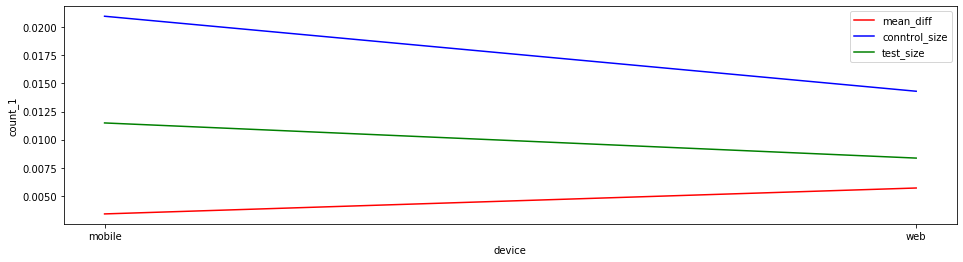

In [23]:
device_mc_0 = mean_count(df_0_nloc,group_var='device',target_var='converted')
device_mc_0['count'] = device_mc_0['count'] /(5*10**6)
device_mc_1 = mean_count(df_1_nloc,group_var='device',target_var='converted')
device_mc_1['count'] = device_mc_1['count'] /(5*10**6)
device_mc_0['mean'] = device_mc_0['mean'] - device_mc_1['mean']
device_mc_0['count_1'] = device_mc_1['count']
mc_plot2(device_mc_0,groupvar = 'device')

#### Operative System

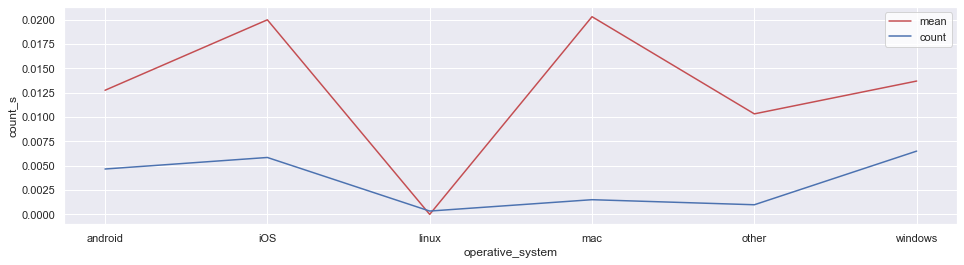

In [73]:
opsys_mc_1 = mean_count(df_1_nloc,group_var='operative_system',target_var='converted')
opsys_mc_1['count_s'] = opsys_mc_1['count'] /(5*10**6)
mc_plot(opsys_mc_1,groupvar = 'operative_system')

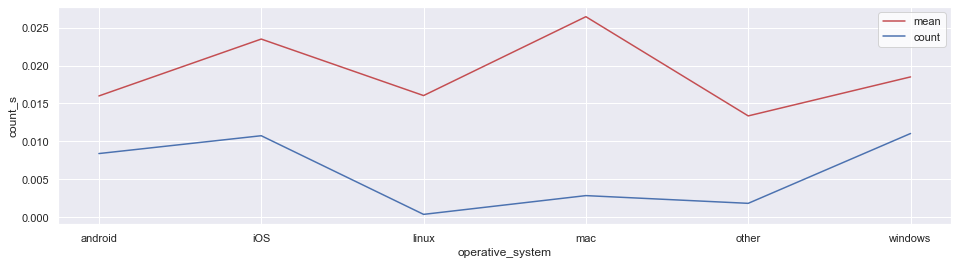

In [74]:
opsys_mc_0 = mean_count(df_0_nloc,group_var='operative_system',target_var='converted')
opsys_mc_0['count_s'] = opsys_mc_0['count'] /(5*10**6)
mc_plot(opsys_mc_0,groupvar = 'operative_system')

In [75]:
opsys_mc_1.columns = ['source','mean_1','count_1','count_s_1']
opsys_mc_1['mean_0'] = opsys_mc_0['mean']
opsys_mc_1['count_0'] = opsys_mc_0['count']
opsys_mc_1

,source,mean_1,count_1,count_s_1,mean_0,count_0
0,android,0.012748,23297,0.004659,0.015997,42008
1,iOS,0.019986,29221,0.005844,0.023493,53761
2,linux,0.000000,1702,0.000340,0.016046,1932
3,mac,0.020305,7535,0.001507,0.026441,14296
4,other,0.010324,4940,0.000988,0.013365,9203
5,windows,0.013695,32493,0.006499,0.018505,55228


In [76]:
test_loop(opsys_mc_1)

0

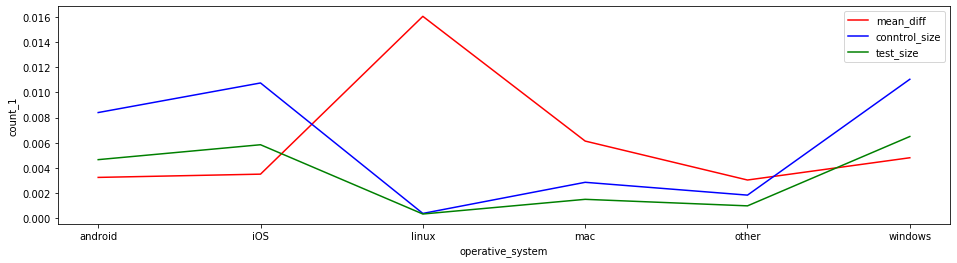

In [26]:
opsys_mc_0 = mean_count(df_0_nloc,group_var='operative_system',target_var='converted')
opsys_mc_0['count'] = opsys_mc_0['count'] /(5*10**6)
opsys_mc_1 = mean_count(df_1_nloc,group_var='operative_system',target_var='converted')
opsys_mc_1['count'] = opsys_mc_1['count'] /(5*10**6)
opsys_mc_0['mean'] = opsys_mc_0['mean'] - opsys_mc_1['mean']
opsys_mc_0['count_1'] = opsys_mc_1['count']
mc_plot2(opsys_mc_0,groupvar = 'operative_system')

#### Latitude

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a20af0400>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a221e9438>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2a2309b0>},
    x  display_column  value_lower  value_upper percentile_column  \
 0  0   [19.7, 29.88)        19.70        29.88        [0, 11.11)   
 1  1  [29.88, 33.23)        29.88        33.23    [11.11, 22.22)   
 2  2  [33.23, 34.11)        33.23        34.11    [22.22, 33.33)   
 3  3  [34.11, 36.68)        34.11        36.68    [33.33, 44.44)   
 4  4  [36.68, 38.91)        36.68        38.91    [44.44, 55.56)   
 5  5  [38.91, 40.67)        38.91        40.67    [55.56, 66.67)   
 6  6   [40.67, 41.1)        40.67        41.10    [66.67, 77.78)   
 7  7   [41.1, 42.39)        41.10        42.39    [77.78, 88.89)   
 8  8  [42.39, 61.18]        42.39        61.18      [88.89, 100]   
 
    percentile_lower  percentile_upper  count  converted  
 

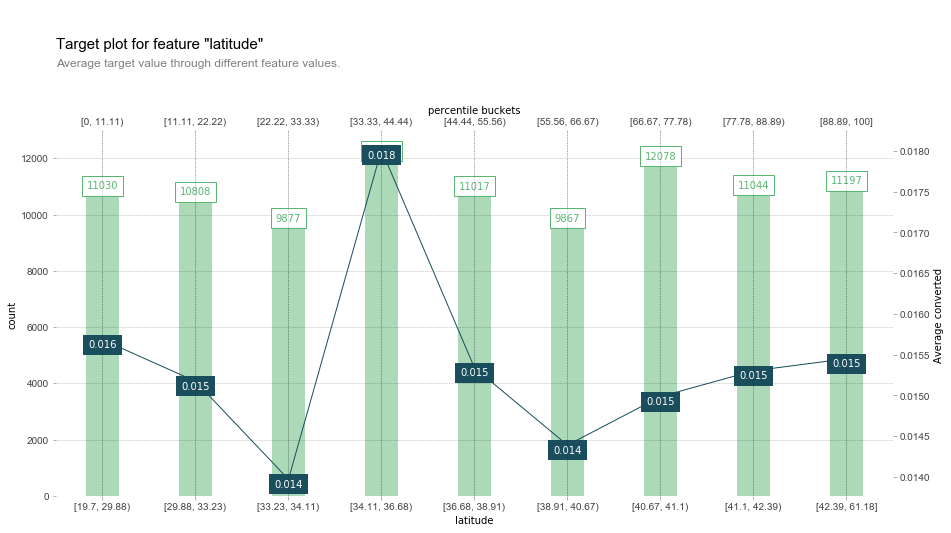

In [27]:
target_plot(
    df=df_1_nloc, feature='lat', feature_name='latitude', target='converted', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a235795c0>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2352bda0>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2c3c6358>},
    x  display_column  value_lower  value_upper percentile_column  \
 0  0   [19.7, 29.88)        19.70        29.88        [0, 11.11)   
 1  1  [29.88, 33.23)        29.88        33.23    [11.11, 22.22)   
 2  2  [33.23, 34.11)        33.23        34.11    [22.22, 33.33)   
 3  3  [34.11, 36.56)        34.11        36.56    [33.33, 44.44)   
 4  4  [36.56, 38.89)        36.56        38.89    [44.44, 55.56)   
 5  5  [38.89, 40.67)        38.89        40.67    [55.56, 66.67)   
 6  6   [40.67, 41.1)        40.67        41.10    [66.67, 77.78)   
 7  7   [41.1, 42.38)        41.10        42.38    [77.78, 88.89)   
 8  8  [42.38, 61.18]        42.38        61.18      [88.89, 100]   
 
    percentile_lower  percentile_upper  count  converted  
 

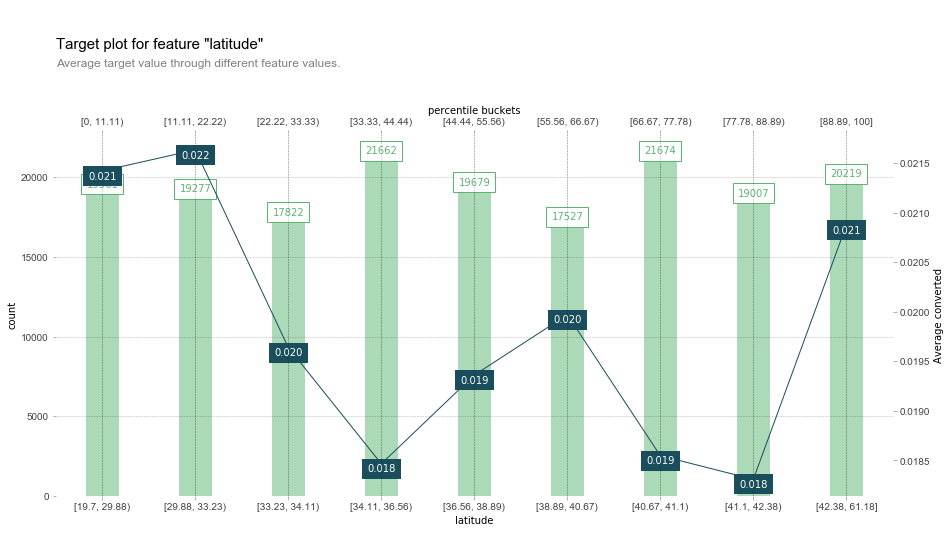

In [28]:
target_plot(
    df=df_0_nloc, feature='lat', feature_name='latitude', target='converted', show_percentile=True)

#### Longitude

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2a2c5908>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2a26dd30>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a247a82e8>},
    x      display_column  value_lower  value_upper percentile_column  \
 0  0   [-157.8, -119.21)      -157.80      -119.21        [0, 11.11)   
 1  1  [-119.21, -117.04)      -119.21      -117.04    [11.11, 22.22)   
 2  2   [-117.04, -97.75)      -117.04       -97.75    [22.22, 33.33)   
 3  3     [-97.75, -93.8)       -97.75       -93.80    [33.33, 44.44)   
 4  4     [-93.8, -87.54)       -93.80       -87.54    [44.44, 55.56)   
 5  5    [-87.54, -82.29)       -87.54       -82.29    [55.56, 66.67)   
 6  6    [-82.29, -77.43)       -82.29       -77.43    [66.67, 77.78)   
 7  7    [-77.43, -73.94)       -77.43       -73.94    [77.78, 88.89)   
 8  8     [-73.94, 30.31]       -73.94        30.31      [88.89, 100]   
 
    percentile_lower

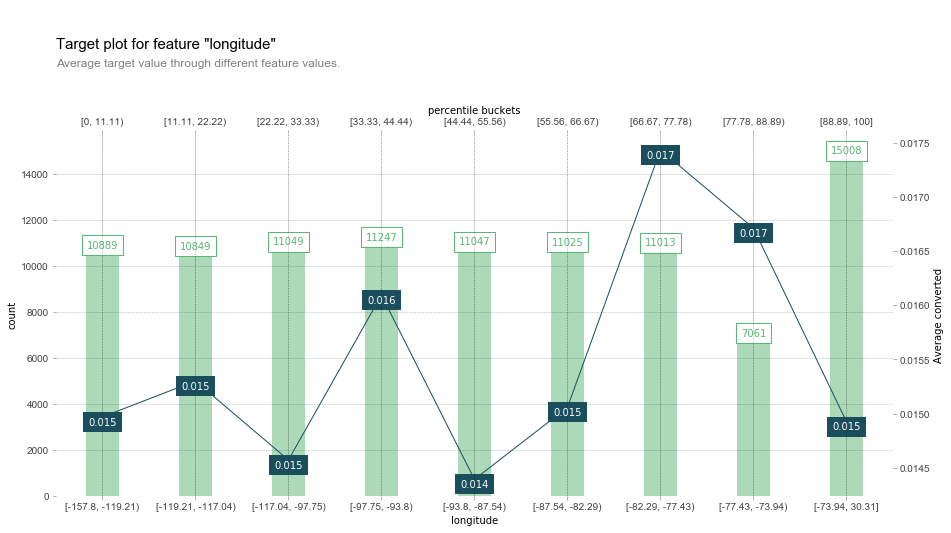

In [29]:
target_plot(
    df=df_1_nloc, feature='long', feature_name='longitude', target='converted', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a20a7b048>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2c1e2898>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2c28e940>},
    x      display_column  value_lower  value_upper percentile_column  \
 0  0   [-157.8, -119.21)      -157.80      -119.21        [0, 11.11)   
 1  1  [-119.21, -117.04)      -119.21      -117.04    [11.11, 22.22)   
 2  2   [-117.04, -97.75)      -117.04       -97.75    [22.22, 33.33)   
 3  3    [-97.75, -93.93)       -97.75       -93.93    [33.33, 44.44)   
 4  4    [-93.93, -87.49)       -93.93       -87.49    [44.44, 55.56)   
 5  5       [-87.49, -82)       -87.49       -82.00    [55.56, 66.67)   
 6  6       [-82, -77.34)       -82.00       -77.34    [66.67, 77.78)   
 7  7    [-77.34, -73.94)       -77.34       -73.94    [77.78, 88.89)   
 8  8     [-73.94, 30.31]       -73.94        30.31      [88.89, 100]   
 
    percentile_lower

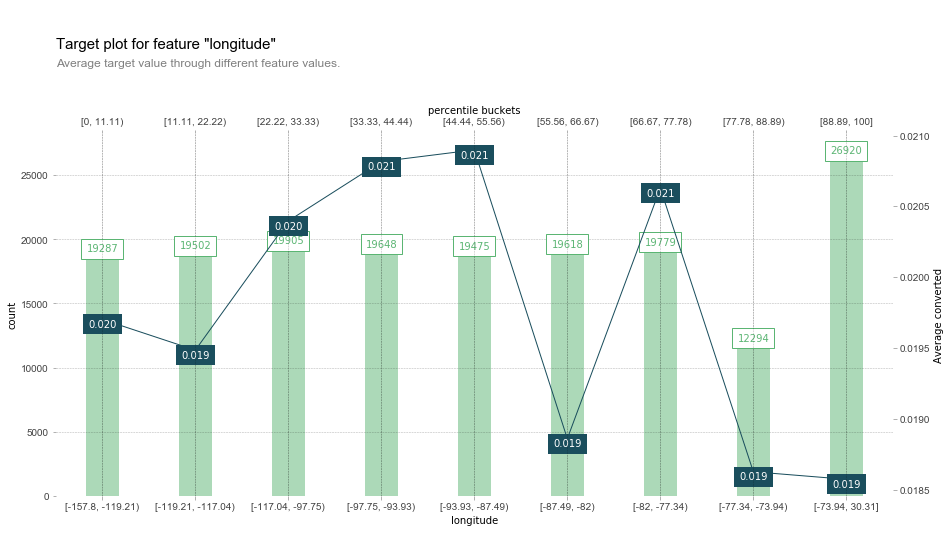

In [30]:
target_plot(
    df=df_0_nloc, feature='long', feature_name='longitude', target='converted', show_percentile=True)

#### Timestamp

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a20ed1978>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a20dc3dd8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2404b390>},
    x        display_column   value_lower   value_upper percentile_column  \
 0  0  [14252.55, 14262.48)  14252.546520  14262.479700        [0, 11.11)   
 1  1  [14262.48, 14270.21)  14262.479700  14270.209863    [11.11, 22.22)   
 2  2  [14270.21, 14280.27)  14270.209863  14280.267367    [22.22, 33.33)   
 3  3  [14280.27, 14287.64)  14280.267367  14287.638610    [33.33, 44.44)   
 4  4  [14287.64, 14297.81)  14287.638610  14297.810943    [44.44, 55.56)   
 5  5  [14297.81, 14305.63)  14297.810943  14305.633097    [55.56, 66.67)   
 6  6  [14305.63, 14314.38)  14305.633097  14314.383541    [66.67, 77.78)   
 7  7  [14314.38, 14323.22)  14314.383541  14323.220522    [77.78, 88.89)   
 8  8  [14323.22, 14331.16]  14323.220522  14331.164020    

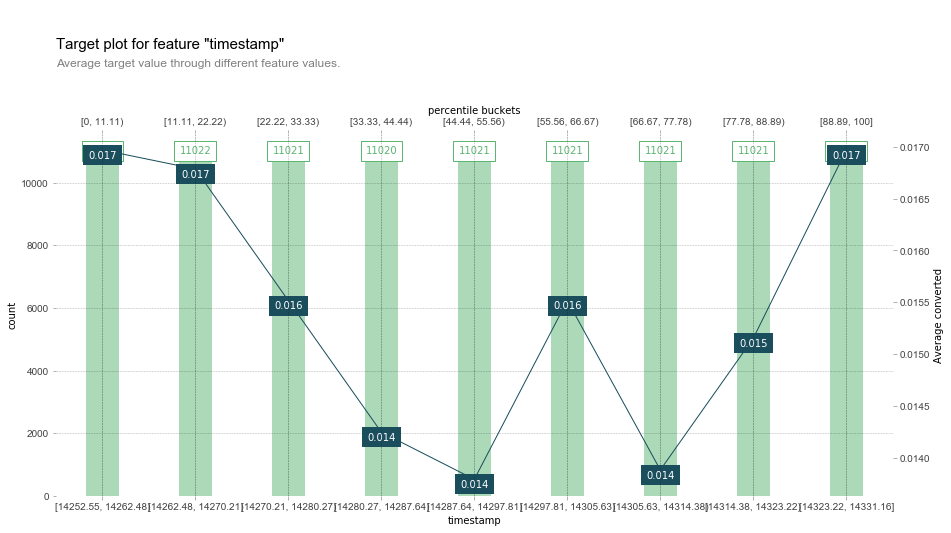

In [31]:
target_plot(
    df=df_1_nloc, feature='timestamp_2', feature_name='timestamp', target='converted', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a20ebfb38>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2ddba668>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2dd2abe0>},
    x        display_column  value_lower  value_upper percentile_column  \
 0  0  [14252.55, 14262.47)  14252.55160  14262.47242        [0, 11.11)   
 1  1  [14262.47, 14270.15)  14262.47242  14270.15140    [11.11, 22.22)   
 2  2  [14270.15, 14280.43)  14270.15140  14280.43085    [22.22, 33.33)   
 3  3  [14280.43, 14287.66)  14280.43085  14287.65586    [33.33, 44.44)   
 4  4  [14287.66, 14297.68)  14287.65586  14297.68315    [44.44, 55.56)   
 5  5  [14297.68, 14305.56)  14297.68315  14305.55565    [55.56, 66.67)   
 6  6  [14305.56, 14314.25)  14305.55565  14314.25025    [66.67, 77.78)   
 7  7  [14314.25, 14323.17)  14314.25025  14323.16929    [77.78, 88.89)   
 8  8  [14323.17, 14331.17]  14323.16929  14331.16785      [88.89, 100]   
 


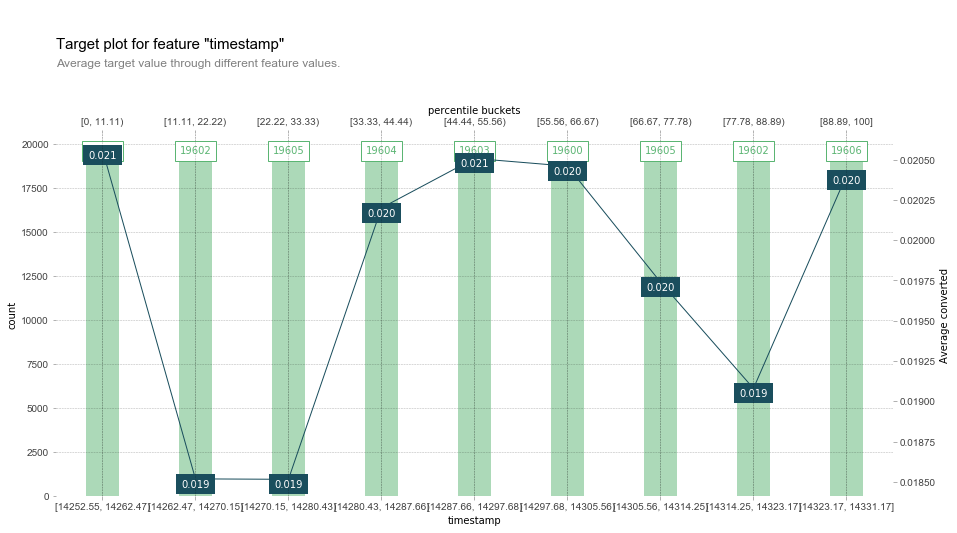

In [32]:
target_plot(
    df=df_0_nloc, feature='timestamp_2', feature_name='timestamp', target='converted', show_percentile=True)

In [33]:
def plot_bin(var,df,bin_number):
    sns.set(rc={'figure.figsize':(10,4)})
    var_df = pd.DataFrame(df[var].value_counts(bins = bin_number,normalize=True,sort=False,dropna=False))
    var_df[var] = np.hstack(var_df.values)
    var_df['mid'] = var_df.index.mid.map(lambda x : round(x,2))
    # lat_df['lat_left'] = lat_df.index.left
    # lat_df['lat_right'] = lat_df.index.right
    # lat_df['interval'] = lat_df['lat_right']-lat_df['lat_left']
    var_df.columns = ['count_percent','mid_point']
    sns.barplot(data=var_df, y='count_percent', x='mid_point').set_title(var)

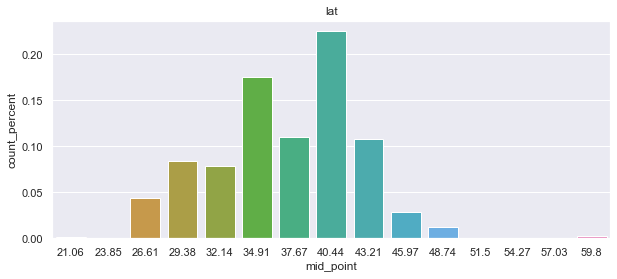

In [34]:
plot_bin(var='lat',df=df,bin_number=15)

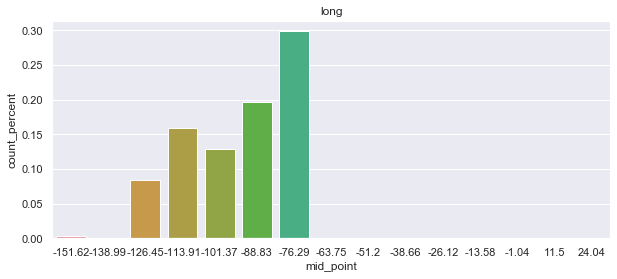

In [35]:
plot_bin(var='long',df=df,bin_number=15)